# BNKE&EA Preliminary - Brokers' notes classification and clustering

18/04/2018 @MAV Python 3 (compatible with PyPDF2)
<br><br>Introduction: This notebook is a first attempt at classifying brokers' notes betwwen categories (single stock, sector, macroeconomy ...) and sub-categories (Capital, human resources, outstanding event ...).
<br>--

Import all necessary packages and modules

In [1]:
import os
import time
import re

import pandas as pd
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.svm import SVC

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

import nltk
import spacy
nlp=spacy.load('en')

import PyPDF2

## Preliminary: construct database

Construct PDF database as a Panda DataFrame from Numpy array

In [2]:
#This function takes a folder path as an argument, scans for PDFs and returns a dataframe with metadata
def my_dataframe_creator(my_folder_path, my_type):
    columns = ["name_file", "size_file", "name_author", "name_category",
               "name_company", "date_creation", "name_topic", "title_document",
               "count_pages", "type_isSingleStock"]
    dataframe = pd.DataFrame(index = [], columns = columns)
    
    for file_ in os.listdir(my_folder_path):
        file_extension = os.path.splitext(file_)[1]
        if file_extension == '.pdf':
            
            #Initializing Numpy array and storing basic file data
            try:
                info = np.array([os.path.basename(file_)[:-4], os.stat(my_folder_path + '/' + file_).st_size])
                reader = PyPDF2.PdfFileReader(open(my_folder_path + '/' + file_, 'rb'), strict=False)
                
                #Adding metadata if available
                for key in ['/Author', '/Category', '/Company', '/CreationDate', '/Subject', '/Title']:
                    info = np.append(info, [reader.getDocumentInfo().get(key)])
                    
                #Adding inside PDF data
                page_count = reader.numPages
                info = np.append(info, [page_count, my_type])
                
                #Adding current file info to global DataFrame
                dataframe.loc[len(dataframe)] = info
            except:
                pass
            
    return dataframe

Store "True" as "Single stock" related notes

In [3]:
path_false = "/media/sf_Shared/Project_BNKE-EA/Database/Documents_NotesBroker_20180416/IsNot_SingleStock"
path_true = "/media/sf_Shared/Project_BNKE-EA/Database/Documents_NotesBroker_20180416/Is_SingleStock"

In [4]:
start_ = time.time()
dataframe_false = my_dataframe_creator(path_false, False)
print("Runtime is " + str(time.time() - start_) + "s")

Runtime is 11.515943765640259s


In [5]:
start_ = time.time()
dataframe_true = my_dataframe_creator(path_true, True)
print("Runtime is " + str(time.time()- start_) + "s")

Runtime is 10.184224367141724s


In [6]:
my_dataframe = pd.concat([dataframe_true, dataframe_false])
my_dataframe.head()

,name_file,size_file,name_author,name_category,name_company,date_creation,name_topic,title_document,count_pages,type_isSingleStock
0,"SanfordCBernsteinCo,LLC_USRailsKeyissuesfor1Q-...",575572,David Vernon,None,None,D:20180411160154,,US Rails: Key issues for 1Q - Market appears n...,16,1
1,"SanfordCBernsteinCo,LLC_USSemiconductorseSport...",280528,"Stacy A. Rasgon, Ph.D.",None,None,D:20180410054427,,U.S. Semiconductors: eSports - The gear you ne...,18,1
2,"SanfordCBernsteinCo,LLC_USVideoGames(ATVI,EA)I...",363726,Todd Juenger,None,None,D:20180412212816,,"U.S. Video Games (ATVI, EA): It's time we had ...",15,1
3,"SanfordCBernsteinCo,LLC_V,MA,PYPL,FDC1Q18Previ...",917547,"Harshita Rawat, CFA",None,None,D:20180420071624,,"V, MA, PYPL, FDC 1Q18 Preview: Positive setup ...",36,1
4,"SanfordCBernsteinCo,LLC_WeekendConsumerBlastTo...",994127,Alexia Howard,None,None,D:20180419210351,,Weekend Consumer Blast: To be or not to be: Wh...,22,1


Define the categories we want to split our data into

In [7]:
my_categories = ["Single Stock","Strategic sector analysis","Macro analysis"]
my_subcategories = ["Capital Changes (SEO, capital reduction etc.)", "Externalities", "M&A", "Management Changes",
                   "Partnership", "Results", "Solvency", "Strategic Changes"]

Parse file titles

In [8]:
my_dataframe["tokenized_name_file"] = my_dataframe["name_file"]
my_names = my_dataframe["tokenized_name_file"].as_matrix()

In [9]:
#This function takes an array as an argument and returns it with standardized strings
def my_names_standardizer(input_):
    if isinstance(input_,str):
        input_ = re.sub(r"(\w)([A-Z])",r"\1 \2", input_[:-13])
        input_ = re.sub(r"[_,()-\]\[~#]"," ", input_)
        input_ = re.sub("\s+", ' ', input_)
        input_ = input_.lower()
    else:
        for i, name in enumerate(input_):
            name = re.sub(r"(\w)([A-Z])",r"\1 \2", name[:-13])
            name = re.sub(r"[_,()]"," ", name)
            name = re.sub("\s+", ' ', name)
            name = name.lower()
            input_[i] = name
    return input_

In [10]:
my_names = my_names_standardizer(my_names)

In [11]:
all_words = [word for name in my_dataframe['tokenized_name_file'] for word in str.split(name)]
print("Total word count = " + str(len(all_words)))
my_vocabulary = list(set(all_words))
print("Total vocabulary length = " + str(len(my_vocabulary)))

Total word count = 6558
Total vocabulary length = 2612


In [12]:
my_dataframe.head()

,name_file,size_file,name_author,name_category,name_company,date_creation,name_topic,title_document,count_pages,type_isSingleStock,tokenized_name_file
0,"SanfordCBernsteinCo,LLC_USRailsKeyissuesfor1Q-...",575572,David Vernon,None,None,D:20180411160154,,US Rails: Key issues for 1Q - Market appears n...,16,1,sanford cbernstein co l lc us rails keyissuesf...
1,"SanfordCBernsteinCo,LLC_USSemiconductorseSport...",280528,"Stacy A. Rasgon, Ph.D.",None,None,D:20180410054427,,U.S. Semiconductors: eSports - The gear you ne...,18,1,sanford cbernstein co l lc us semiconductorse ...
2,"SanfordCBernsteinCo,LLC_USVideoGames(ATVI,EA)I...",363726,Todd Juenger,None,None,D:20180412212816,,"U.S. Video Games (ATVI, EA): It's time we had ...",15,1,sanford cbernstein co l lc us video games a tv...
3,"SanfordCBernsteinCo,LLC_V,MA,PYPL,FDC1Q18Previ...",917547,"Harshita Rawat, CFA",None,None,D:20180420071624,,"V, MA, PYPL, FDC 1Q18 Preview: Positive setup ...",36,1,sanford cbernstein co l lc v m a p yp l f dc1 ...
4,"SanfordCBernsteinCo,LLC_WeekendConsumerBlastTo...",994127,Alexia Howard,None,None,D:20180419210351,,Weekend Consumer Blast: To be or not to be: Wh...,22,1,sanford cbernstein co l lc weekend consumer bl...


##  First strategy: raw Bag of Words and PCA

In [13]:
#This function takes an array of strings as argument and returns their BoW representation
def my_count(data):
    vectorizer = sklearn.feature_extraction.text.CountVectorizer()
    counted = vectorizer.fit_transform(data)
    return counted, vectorizer

In [14]:
analysis = 'Title'

In [15]:
if analysis == 'Title':
    my_list_names = my_dataframe['tokenized_name_file'].tolist()
    my_list_labels = my_dataframe['type_isSingleStock'].tolist()
if analysis == 'First page':
    my_list_names = my_dataframe['firstpagetext'].tolist()
    my_list_labels = my_dataframe['category'].tolist()

In [16]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(my_list_names, my_list_labels,
                                                                            test_size=0.2, random_state=40)
X_train_counts, count_vectorizer = my_count(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [17]:
X_train_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
print(count_vectorizer.vocabulary_.get('high'))

851


In [19]:
#This function takes as arguments: data and labels, and returns a 2-dimensional plot for the data
def plot_LSA(test_data, test_labels, plot=True):
    lsa = TruncatedSVD(n_components = 2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
        
    if plot:
        color_map = {}
        handles = []
            
        for category in set(test_labels):
            color = np.random.random(size=3)                
            color_map[category] = color
            handles.append(mpatches.Patch(color = color, label = category))
        color_column = []
            
        for label in test_labels:
            color_column.append(color_map[label])
        
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c = color_column)            
        plt.legend(handles=handles)
    return lsa_scores

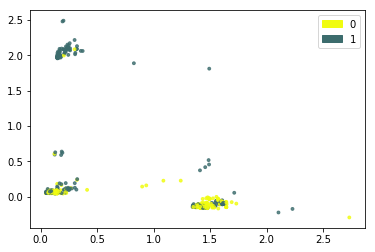

In [20]:
plot_LSA(X_train_counts, Y_train)
plt.show()

Clustering opportunities are poor: need for a broader DB w/ better preprocessing (TF IDF and Word2Vec)

In [21]:
#This function takes as arguments the test and predicted output and returns performance measures in a dataframe
def get_metrics(y_test, y_predicted):
    precision = sklearn.metrics.precision_score(y_test, y_predicted, pos_label = None, average = 'weighted')
    recall = sklearn.metrics.recall_score(y_test, y_predicted, pos_label = None, average='weighted')
    f1 = sklearn.metrics.f1_score(y_test, y_predicted, pos_label = None, average='weighted')
    accuracy = sklearn.metrics.accuracy_score(y_test, y_predicted)
    return pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1]})

In [22]:
my_svc_counts = SVC(kernel = 'rbf').fit(X_train_counts, Y_train)
Y_predicted_counts = my_svc_counts.predict(X_test_counts)
get_metrics(Y_test, Y_predicted_counts)

,Accuracy,F1,Precision,Recall
0,0.706897,0.697913,0.829928,0.706897


## Second strategy: TF IDF and Word2Vec

In [23]:
#This function takes as an argument vector representation for strings and erturn tfidf analyzed vectors
def tfidf(data):
    tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

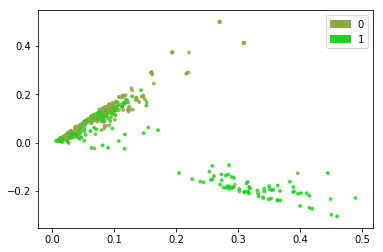

In [24]:
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
fig = plt.figure()
plot_LSA(X_train_tfidf,Y_train)
plt.show()

The results are much better, we can try to fit a model overe the data <br>
Let's first try to fit a simple logistic regression model.

In [25]:
clf_tfidf = sklearn.linear_model.LogisticRegression(C=30, class_weight='balanced',
                                                    solver='newton-cg', multi_class='multinomial',
                                                    n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, Y_train)
Y_predicted_tfidf=clf_tfidf.predict(X_test_tfidf)
get_metrics(Y_test, Y_predicted_tfidf)

,Accuracy,F1,Precision,Recall
0,0.862069,0.863234,0.872594,0.862069


Performance with this model are pretty good but we would like to bring them up to around a few BP of mistakes.

In [26]:
my_cm = sklearn.metrics.confusion_matrix(Y_test, Y_predicted_tfidf)
my_cm

array([[43,  4],
       [12, 57]])

TP=57, FP=1, FN=4, TN=58 ;
There are slightly more FN than FP, meaning the model is slightly more likely to be wrong when categorizing as Not SIngleStock while they are actually.

In [27]:
for i,name in enumerate(X_test):
    if Y_test[i]!=Y_predicted_tfidf[i]:
        print('Predicted wrong: '+str(Y_predicted_tfidf[i])+" - " +str(name))

Predicted wrong: 0 - morgan stanley hormel foods expect reversalin recent outperformance
Predicted wrong: 0 - morgan stanley pp lcorp digging intothe valueofthe uk business
Predicted wrong: 0 - morgan stanley amazon best buy alexa show me the nearest best buy
Predicted wrong: 1 - morgan stanley videoe bay inc payments+advertising=60+higher free cash flow double upgradeto ow
Predicted wrong: 0 - morgan stanley canadian pacific railway ltd1 qinline2 key catalysts ahead
Predicted wrong: 0 - morgan stanley bb tcorporation1 q18 first pass expense beata plus focuson capital return
Predicted wrong: 0 - morgan stanley sherwin-williams co february pw psales decelerate march hi rs modestly accelerates as february hi rs revised up
Predicted wrong: 0 - morgan stanley abbott laboratories sustainable6-7 should drive expansion
Predicted wrong: 0 - morgan stanley boeing co improved risk-reward post announced tariffs
Predicted wrong: 0 - morgan stanley omnicom group inc1 q18 results better than anticip

Based off these good performances, let's try to find the most discriminating words

In [28]:
#This function takes as argument the tfidf vectorizer and model to return the x best and worst words
def get_ranked_words(vectorizer, model, n=10):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(j,index_to_word[i]) for i,j in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, reverse = True)
        tops = sorted(sorted_coeff[:n])
        bottoms = sorted_coeff[-n:]
        classes[class_index] = {'tops':tops, 'bottoms':bottoms}
    return classes

In [29]:
importance = get_ranked_words(tfidf_vectorizer,clf_tfidf)
importance

{0: {'bottoms': [(-1.8363907495065248, 'equity'),
   (-1.9125347061008966, 'march'),
   (-1.9302841502168422, 'jp'),
   (-2.102381806573149, 'data'),
   (-2.328660231023758, 'morgan'),
   (-2.368141630489377, 'april'),
   (-2.386812878246769, 'stanley'),
   (-2.538870931614393, 'weekly'),
   (-2.570236249909157, 'strategy'),
   (-3.518157171094269, 'china')],
  'tops': [(1.7963844021343023, 'first'),
   (1.8659496024369608, 'johnson'),
   (1.866510321452427, 'pass'),
   (2.1257494170935187, 'inc1'),
   (2.6103714146369876, 'cbernstein'),
   (2.6103714146369876, 'lc'),
   (2.6103714146369876, 'sanford'),
   (2.9508618885713056, 'corp'),
   (3.4731528096458435, 'co'),
   (5.098804676050839, 'inc')]}}

The model shows clear learning pattern with the different company suffixes but also bernstein and sanford which seem odd. <br>
Let's try to use Word2vec out of curiosity.

In [30]:
#This function takes as an argument the list of names/tokens and returns the average word embeddings
def get_word2vec_embeddings(sentence):
    vectorized = [nlp(word).vector for word in sentence.split()]
    embeddings = np.divide(sum(vectorized),len(vectorized))
    return embeddings

In [31]:
tokens = []
for name in my_list_names:
    tokens.append(get_word2vec_embeddings(name))

In [32]:
tsne_model = TSNE(perplexity = 40, n_components = 2, init = 'pca', n_iter = 2500, random_state = 23)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

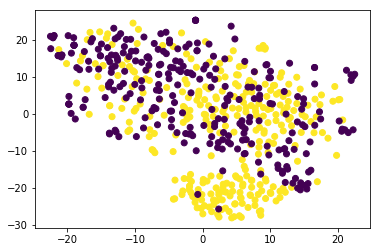

In [33]:
plt.figure()
plt.scatter(x, y, c = my_list_labels)

Mixed feeling about the use of Word2Vec: may require deeper study into potential applications for supervised learning<br>
Let's try to fit a slightly more sophisticated model: an SVM for instance

In [36]:
my_svc_tfidf = SVC(kernel = 'linear').fit(X_train_tfidf, Y_train)
Y_predicted_tfidf_SVC = my_svc_tfidf.predict(X_test_tfidf)
get_metrics(Y_test, Y_predicted_tfidf_SVC)

,Accuracy,F1,Precision,Recall
0,0.862069,0.863312,0.877347,0.862069


Looks like both models are doing the same predictions, let's try to enrich the representation vectors before fitting an SVM.

## Third strategy: meta-data and co-occurences over the tickers

In order to use co-occurences techniques, we will need to definetely extract part of the PDF to text. We will first focus on the first page for that.

In [37]:
my_text_path = '/media/sf_Shared/Project_BNKE-EA/Database/Documents_NotesBroker_20180509/ExtractedText_Last_v0.csv'
my_ticker_path = '/media/sf_Shared/Project_BNKE-EA/Database/BDD_Ticker_20180428/Company Screening Report 2.xls'

In [38]:
my_text_dataframe = pd.read_csv(my_text_path)
my_ticker_dataframe = pd.ExcelFile(my_ticker_path).parse('Screening')

In [39]:
my_text_dataframe['size_file'] = my_dataframe['size_file'].tolist()
my_text_dataframe['count_pages'] = my_dataframe['count_pages'].tolist()

ValueError: Length of values does not match length of index

In [14]:
my_text_dataframe.head()

,Unnamed: 0,filename,category,firstpagetext,wordscount
0,0,"MorganStanley_UKEconomicsGDPCommentWeak,ButMay...",Economy,"April 27, 2018 10:39 AM GMT\n\nUK Economics \n...",784
1,1,MorganStanley_UKEconomicsStrategyMPCOnceaYearI...,Economy,"May 10, 2018 06:11 PM GMT\n\nUK Economics & St...",708
2,2,MorganStanley_UKEconomicsStrategyMPCPreviewHik...,Economy,"April 30, 2018 04:00 AM GMT\n\nUK Economics & ...",738
3,3,MorganStanley_UKEconomicsStrategyMPCWeakPMItoD...,Economy,"May 3, 2018 10:25 AM GMT\n\nUK Economics & Str...",821
4,4,MorganStanley_USAsiaTradePolicyCardsontheTable...,Economy,"April 4, 2018 03:43 PM GMT\n\nUS/Asia Trade Po...",274


Let's first try to explore the patterns within PDF metadata (page count, words count and file size)

In [30]:
x = my_text_dataframe['size_file'].astype(float)
x = (x - np.average(x))*1E-6
x = x.tolist()
y = my_text_dataframe['count_pages'].tolist()
z = my_text_dataframe['wordscount'].tolist()
colors = my_dataframe['type_isSingleStock'].tolist()
my_features=[[x[i],y[i],z[i]] for i in range(len(x))]

In [31]:
my_features_train, my_features_test, my_labels_train, my_labels_test = sklearn.model_selection.train_test_split(
    myFeatures, colors, test_size = 0.2, random_state = 40)

In [32]:
start_ = time.time()
my_svc_meta=SVC(kernel='linear').fit(my_features_train, my_labels_train)
print("Runtime is " + str(time.time() - start_) + "s")

Runtime is 2.9581406116485596s


In [33]:
my_labels_predicted = my_svc_meta.predict(my_features_test)
get_metrics(my_labels_test, my_labels_predicted)

(0.6166666666666667,
 0.6861403508771929,
 0.6166666666666667,
 0.5812393033323267)

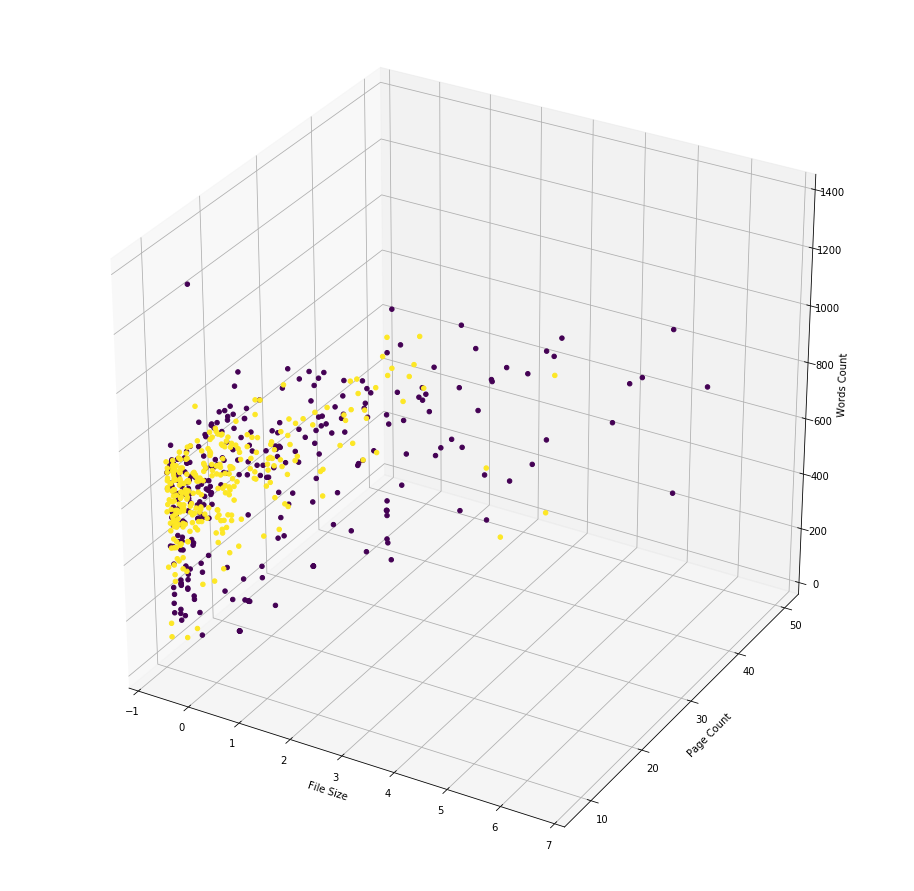

In [34]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x,y,z,c = colors,depthshade = False)
ax.set_xlabel('File Size')
ax.set_ylabel('Page Count')
ax.set_zlabel('Words Count')
plt.show()

Simple 3D plot and attempted SVM fitting doesn't show any clear pattern<br>
Let's work on the custom co-occurence technique now. We will use a list of tickers whose company are of interest to us

In [35]:
my_tickers  = my_tickers_dataframe['Company Name']
my_tickers[14]

'Wells Fargo & Company '

In [36]:
exclusion_list = ['The ','the ',' Corporation',' corporation',' Corp',' corp',' Corp.',' corp.',' Incorporated',' incorporated',
               ' Inc.',' inc.',' Limited',' limited',' Ltd.',' ltd.','L.P.',' Laboratories',' laboratories',' Funds',' funds',
               ' Fund',' fund',' Holdings','holdings',' Holding',' holding',' Company',' company',' & Company',
               ' & company',' Group',' group',' & Co.',' & co.',' Co.',' co.',' .com',',','-']
my_exclusion = '|'.join(exclusion_list)
new_tickers_list = [re.sub(my_exclusion, "", my_tickers[i]) for i in range(len(my_tickers))]
for i in range(len(new_tickers_list)):
        while new_tickers_list[i][-1:] == " ":
            new_tickers_list[i] = new_tickers_list[i][:-1]
        while new_tickers_list[i][:1] == " ":
            new_tickers_list[i] = new_tickers_list[i][1:] 

In [37]:
new_tickers_list[14]

'Wells Fargo'

Building the cooccurence matrix based on company names solely

In [38]:
my_cooc_list = []
for k, document in enumerate(my_text_dataframe['firstpagetext']):
    s = (len(my_text_dataframe['firstpagetext'][k].split(".")),len(new_tickers_list))
    my_text_matrix = np.zeros(s)
    for i, sentence in enumerate(my_text_dataframe['firstpagetext'][k].split(".")):
        for j, ticker in enumerate(new_tickers_list):
            if tiocker in sentence:
                my_text_matrix[i][j]+=1
    my_text_matrix.astype(int)
    my_cooc_list.append(my_text_matrix.T.dot(my_text_matrix))
print("Runtime is " + str(time.time() - start_) + "s")

Runtime is 15.584805727005005s


The resulting matrices are extremely sparse: only 0.7% filled. Let's try to find better data representation

In [39]:
coocstats = []
for ligne in my_cooc_list:
    count_not_empty = 0
    for count, colonne in enumerate(ligne):
        countNotEmpty+=colonne.sum()
    coocstats.append(count_not_empty / count * 100)

In [40]:
cooccurences_train, cooccurences_test, my_labels_cooc_train, my_labels_cooc_test = sklearn.model_selection.train_test_split(coocstats, my_list_labels, test_size=0.2, random_state=40)

In [41]:
my_SVC_cooc=SVC(kernel='linear').fit(np.array(cooccurences_train).reshape(-1, 1),my_labels_cooc_train)
my_labels_cooc_predicted=my_SVC_cooc.predict(np.array(cooccurences_test).reshape(-1, 1))
get_metrics(my_labels_cooc_predicted,my_labels_cooc_test)

(0.6, 0.6577938316198944, 0.6, 0.6126473124461052)

In [42]:
w=my_SVC_cooc.coef_

In [43]:
color_dict = {0:'orange',1:'green'}
colors_cooc=[color_dict[label] for label in my_labels_cooc_test]

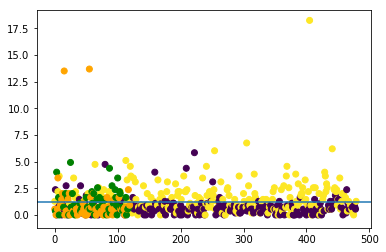

In [44]:
plt.figure()
plt.scatter(range(len(cooccurences_train)),cooccurences_train,c=my_labels_cooc_train)
plt.scatter(range(len(cooccurences_test)),cooccurences_test,c=colors_cooc)
plt.axhline(y=w.tolist()[0][0])

Results are pretty poor, there is no clear pattern for relationship between lots of ticker cooccurences and singlestock labelling contrary to what we expected.

We need to explore better ways to combine the different vector reprensentation for the PDF we are examining

## Fourth strategy: combining the different vector representations

In [38]:
my_list_of_names_tfidf = tfidf(my_list_names)[0]
lsa = TruncatedSVD(n_components = 20)
lsa.fit(my_list_of_names_tfidf)
lsa_scores = lsa.transform(my_list_of_names_tfidf)

In [39]:
a = [[element] for element in x]
b = [[element] for element in y]
c = [[element] for element in z]
d = [[element] for element in Coocstats]

NameError: name 'x' is not defined

In [47]:
my_combined_features = np.concatenate((a,b,c,d,lsa_scores),1)

In [48]:
my_combined_features_train, my_combined_features_test, my_labels_train, my_labels_test = sklearn.model_selection.train_test_split(my_combined_features, myListofLabels, test_size=0.2,random_state=40)

In [184]:
my_svc_combined = SVC(kernel='linear').fit(my_combined_features_train, my_labels_train)
my_labels_predicted = my_svc_combined.predict(my_combined_features_test)
get_metrics(my_labels_predicted, my_labels_test)

(0.9083333333333333,
 0.9116791701398537,
 0.9083333333333333,
 0.9084288791605865)

For whole TFIDF sparse matrix into SVM model, perf are (0.925, 0.9261878299527647, 0.925, 0.9250156260851448) <br>
For PCA-preprocessed TFIDF matrices with 20 components, perf are (0.9083333333333333, 0.9116791701398537, 0.9083333333333333, 0.9084288791605865)

## Extended clustering: exploring 3D groups

In [40]:
my_csv_path = '/media/sf_Shared/Project_BNKE-EA/Database/Documents_NotesBroker_20180509/_extracted_text.csv'
dataframe = pd.read_csv(my_csv_path)
len(dataframe)

1190

In [41]:
dataframe['standardized_file_name'] = my_names_standardizer(dataframe['filename'].tolist())
simple_category = {'SingleStock': 'SingleStock', 'Economy': 'NotSingleStock', 'Industry': 'NotSingleStock'}
dataframe['category_2D']=[simple_category[category] for category in dataframe['category']]
rows_to_drop = []
for i in range(len(dataframe)):
    if len(dataframe['standardized_file_name'][i].split(' ')) < 7:
        rows_to_drop.append(i)
cleaned_dataframe = dataframe.drop(rows_to_drop)
len(cleaned_dataframe)

928

In [74]:
X_full, Y_full = dataframe['standardized_file_name'].tolist(), dataframe['category_2D'].tolist()

In [42]:
X_train3D, X_test3D, Y_train3D, Y_test3D = sklearn.model_selection.train_test_split(dataframe['standardized_file_name'].tolist(), dataframe['category_2D'].tolist(), test_size=0.2,random_state=40)

In [63]:
X_full_tfidf, tfidf_vectorizer_full = tfidf (X_full)

In [43]:
X_train3D_tfidf, tfidf_vectorizer = tfidf(X_train3D)
X_test3D_tfidf = tfidf_vectorizer.transform(X_test3D)

In [60]:
sklearn.externals.joblib.dump(tfidf_vectorizer_full, 'my_2D_tfidf_full_model.pkl',compress=9)

['my_2D_tfidf_full_model.pkl']

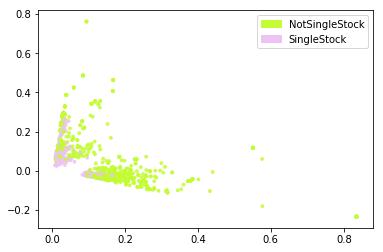

In [66]:
fig = plt.figure()
lsa_scores = plot_LSA(X_train3D_tfidf,Y_train3D)
plt.show()

In [45]:
my_svc_3D_tfidf = SVC(kernel='linear').fit(X_train3D_tfidf, Y_train3D)
Y_predicted3D_tfidf_SVC = my_svc_3D_tfidf.predict(X_test3D_tfidf)
get_metrics(Y_test3D,Y_predicted3D_tfidf_SVC)

,Accuracy,F1,Precision,Recall
0,0.97479,0.974707,0.97478,0.97479


In [46]:
clf_tfidf = sklearn.linear_model.LogisticRegression(C=30, class_weight='balanced',
                                                    solver='newton-cg', multi_class='multinomial',
                                                    n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train3D_tfidf, Y_train3D)
Y_predicted3D_tfidf_SVC = clf_tfidf.predict(X_test3D_tfidf)
get_metrics(Y_test3D,Y_predicted3D_tfidf_SVC)

,Accuracy,F1,Precision,Recall
0,0.97479,0.974707,0.97478,0.97479


In [68]:
clf_tfidf = sklearn.linear_model.LogisticRegression(C=30, class_weight='balanced',
                                                    solver='newton-cg', multi_class='multinomial',
                                                    n_jobs=-1, random_state=40)
clf_tfidf.fit(X_full_tfidf, Y_full)
sklearn.externals.joblib.dump(clf_tfidf, 'my_2D_linear_reg_model.pkl',compress=9)

['my_2D_linear_reg_model.pkl']

In [48]:
list_non_ss = []
labels_non_ss = []
for i in range(len(dataframe)):
    if dataframe['category_2D'][i] == 'NotSingleStock':
        list_non_ss.append(dataframe['first_page_text'][i])
        labels_non_ss.append(dataframe['category'][i])

In [49]:
X_train_2D3D, X_test_2D3D, Y_train_2D3D, Y_test_2D3D = sklearn.model_selection.train_test_split(list_non_ss, labels_non_ss, test_size=0.2,random_state=40)

In [50]:
X_train_2D3D_tfidf, tfidf_vectorizer_2D3D = tfidf(X_train_2D3D)
X_test_2D3D_tfidf = tfidf_vectorizer_2D3D.transform(X_test_2D3D)

In [71]:
X_tfidf_full_2D3D, tfidf_vectorizer_2D3D_full = tfidf(list_non_ss)
sklearn.externals.joblib.dump(tfidf_vectorizer_2D3D, 'my_2D3D_tfidf_model.pkl',compress=9)

['my_2D3D_tfidf_model.pkl']

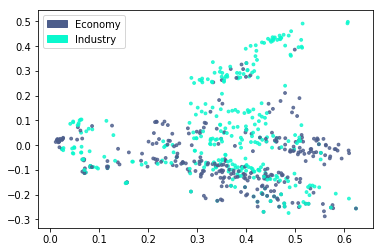

In [51]:
fig = plt.figure()
lsa_scores = plot_LSA(X_train_2D3D_tfidf,Y_train_2D3D)
plt.show()

In [52]:
my_svc_2D3D_tfidf = SVC(kernel='linear').fit(X_train_2D3D_tfidf, Y_train_2D3D)
Y_predicted_2D3D_tfidf_SVC = my_svc_2D3D_tfidf.predict(X_test_2D3D_tfidf)
get_metrics(Y_test_2D3D,Y_predicted_2D3D_tfidf_SVC)

,Accuracy,F1,Precision,Recall
0,0.83125,0.83123,0.831795,0.83125


In [72]:
my_svc_2D3D_tfidf_full = SVC(kernel='linear').fit(X_tfidf_full_2D3D, labels_non_ss)
sklearn.externals.joblib.dump(my_svc_2D3D_tfidf, 'my_2D3D_linear_SVC_model.pkl',compress=9)

['my_2D3D_linear_SVC_model.pkl']

In [54]:
logistic_reg = sklearn.linear_model.LogisticRegression(C=30, class_weight='balanced',
                                                    solver='newton-cg', multi_class='multinomial',
                                                    n_jobs=-1, random_state=40)
logistic_reg.fit(X_train_2D3D_tfidf, Y_train_2D3D)
Y_predicted_2D3D_tfidf_SVC = logistic_reg.predict(X_test_2D3D_tfidf)
get_metrics(Y_test_2D3D,Y_predicted_2D3D_tfidf_SVC)

,Accuracy,F1,Precision,Recall
0,0.8,0.799812,0.801882,0.8


The clusters for Industry and Economy seem well defined but there seem to be 2 different ones for Single Stock: let's try to find out why

## Applying NLP pre-processing methods

In [157]:
#This function takes a string as argument and returns a cleaned string
def my_page_formatter(text):
    text = re.sub("\w*\.\w*@morganstanley.com", '', text)
    text = re.sub("(\(.*\))", '', text)
    text = re.sub("\+(\d+(\s|-)?)+", '', text)
    text = re.sub("\d+\D{0,2}", '', text)
    text = re.sub("[\%\\\|\-\+\~\&]", '', text)
    text = re.sub("\s+", ' ',text)
    return text

In [190]:
def my_lemmatizer(sentence):
    out_ = []
    for word in nlp(sentence):
        out_.append(word.lemma_)
    return ' '.join(out_)

In [191]:
def my_chunks_extractor(sentence):
    out_ = []
    for chunk in nlp(sentence).noun_chunks:
        out_.append(chunk.text)
    return ' '.join(out_)

In [192]:
my_chunks_exctractor(dataframe['first_page_text'][3])

"Jacob.Nell@morganstanley.comShreya.Chander@morganstanley.comMORGAN STANLEY CO INTERNATIONAL PLC+Jacob NellECONOMIST+44 -8724Shreya ChanderSTRATEGIST+44 MPCUK Economics Strategy | PMI Delay Next HikeToday's PMI services some more persistent weakness the growthoutlook We the MPC rates We a May hike a robust rebound the April services PMIprint last week's downside surprise 1Q growth consensusexpectations we evidence a strong rebound inactivity the April services PMI We theMPC 1Q weakness the grounds it volatile andtransitory factors May itshawkish framework rising homemade inflation what we ahawkish majority the MPC.So today's weak rebound the MPC hold we August the services PMI print consensus just a modest acceleration growthmomentum what Markit trend we the MPC hold We a solid 2Q growthrebound the way a hike August However, the risk consumer weakness Brexit uncertainty growth hold Brexit Weak headline print mixed details March's snow-related weakness the PMI services the slowest growt

In [42]:
start_ = time.time()
my_lemmatized_text=[]
for i in range(len(dataframe)):
    output_=[]
    for word in nlp(my_names_standardizer(dataframe['filename'][i])):
        output_.append(word.lemma_)
    for word in nlp(my_page_formatter(dataframe['first_page_text'][i])):
        output_.append(word.lemma_)
    string_output = ' '.join(output_)
    my_lemmatized_text.append(string_output)
my_lemmatized_text
print("Runtime is " + str(time.time() - start_) + "s")

Runtime is 164.62494206428528s


In [41]:
len(dataframe) /3 * 1.1954 /60

7.902922222222222

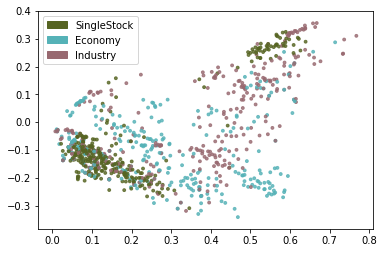

In [43]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(my_lemmatized_text, dataframe['category'],
                                                                            test_size=0.2, random_state=40)
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
fig = plt.figure()
plot_LSA(X_train_tfidf,Y_train)
plt.show()

In [63]:
my_svc_lemma = SVC(kernel='linear').fit(X_train_tfidf, Y_train)
Y_predicted_lemma = my_svc_lemma.predict(X_test_tfidf)
get_metrics(Y_test,Y_predicted_lemma)

,Accuracy,F1,Precision,Recall
0,0.861345,0.860998,0.862196,0.861345


In [66]:
my_page_formatter(dataframe['first_page_text'][4])

"Jenny.MORGAN STANLEY ASIA LIMITEDChetan AhyaECONOMISTMORGAN STANLEY CO. LLCMichael D Zezas, CFASTRATEGISTMORGAN STANLEY ASIA LIMITEDRobin XingECONOMISTMORGAN STANLEY CO. LLCEllen ZentnerECONOMISTMORGAN STANLEY ASIA LIMITEDDerrick Y KamECONOMISTJenny Zheng, CFAECONOMISTMORGAN STANLEY CO. LLCMeredith M PickettSTRATEGISTMORGAN STANLEY ASIA LIMITEDHelen LaiECONOMISTZhipeng CaiECONOMISTUS/Asia Trade PolicyUS/Asia Trade PolicyCards on the TableChina's response to US ariffs was proportionate in size,but faster and more aggressive than expected. We still seethese moves as an aim towards an eventual negotiation, butnote this intrinsically increases risks of a 'protectionist push',forcing markets to reflect elevated uncertainty.Morgan Stanley does and seeks to do business withcompanies covered in Morgan Stanley Research. As aresult, investors should be aware that the firm may have aconflict of interest that could affect the objectivity ofMorgan Stanley Research. Investors should considerMorgan 

In [71]:
start_ = time.time()
my_lemmatized_names = []
for i in range(len(dataframe)):
    output_=[]
    for word in nlp(my_names_standardizer(dataframe['filename'][i])):
        output_.append(word.text)
    string_output = ' '.join(output_)
    my_lemmatized_names.append(string_output)
print("Runtime is " + str(time.time() - start_) + "s")

Runtime is 24.996007680892944s


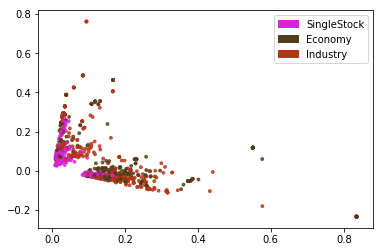

In [74]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(dataframe['stan'], dataframe['category'],
                                                                            test_size=0.2, random_state=40)
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
fig = plt.figure()
plot_LSA(X_train_tfidf,Y_train)
plt.show()

In [75]:
my_svc_lemma = SVC(kernel='linear').fit(X_train_tfidf, Y_train)
Y_predicted_lemma = my_svc_lemma.predict(X_test_tfidf)
get_metrics(Y_test,Y_predicted_lemma)

,Accuracy,F1,Precision,Recall
0,0.861345,0.861374,0.863227,0.861345


In [132]:
for i, string in enumerate(X_train3D):
    X_train3D[i] = re.sub(r"\n"," ",string)
for j,string in enumerate(X_test3D):
    X_test3D[j] = re.sub(r"\n"," ",string)

In [198]:
83.1*97.5

8102.249999999999